In [4]:
!pipreqs . --savepath ./requirements.txt --encoding=utf8 --force --ignore .venv,__pycache__

/bin/bash: line 1: pipreqs: command not found


In [5]:
## Importing required libraries
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve, auc
)

In [6]:
## Read in the file
url = 'https://raw.githubusercontent.com/Renzie74/motor-claims-model/refs/heads/main/data/Kenyan_Motor_Insurance_2023_2024.csv?token=GHSAT0AAAAAADSZAORWOPDXRQO65OS7W4AG2LZ7PWA'
df = pd.read_csv(url)
df.head()

,Year,Policy_ID,Customer_Age,Gender,Region,Vehicle_Type,Vehicle_Age,Vehicle_Value_KES,Vehicle_Engine_Capacity,Use_Purpose,Annual_Premium_KES,Claims_Frequency,Total_Claim_Amount_KES,No_Claim_Bonus_%,Accident_Cause,Policy_Term_Months,Previous_Claims_Count,Driver_Experience_Years,Third_Party_Only,Claims_Status
0,2023,P202300001,58,Male,Nakuru,PSV,19,3229084,2000,Business,203851,1,866500,0,Theft,6,0,38,Yes,1
1,2023,P202300002,43,Male,Thika,Private,3,1739911,2000,Taxi,64471,0,0,20,NaN,6,2,22,No,0
2,2023,P202300003,40,Male,Kakamega,Private,0,2781931,1500,Business,146378,0,0,50,NaN,12,0,22,Yes,0
3,2023,P202300004,46,Male,Nakuru,Private,9,1154811,2500,Personal,59810,0,0,30,NaN,12,0,26,No,0
4,2023,P202300005,63,Female,Nakuru,Commercial,19,3452991,1000,Business,143266,0,0,30,NaN,6,0,41,No,0


##Exploratory Data Analysis

In [7]:
##Checking data shape
df.shape

(2000, 20)

In [8]:
##checking column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year                     2000 non-null   int64 
 1   Policy_ID                2000 non-null   object
 2   Customer_Age             2000 non-null   int64 
 3   Gender                   2000 non-null   object
 4   Region                   2000 non-null   object
 5   Vehicle_Type             2000 non-null   object
 6   Vehicle_Age              2000 non-null   int64 
 7   Vehicle_Value_KES        2000 non-null   int64 
 8   Vehicle_Engine_Capacity  2000 non-null   int64 
 9   Use_Purpose              2000 non-null   object
 10  Annual_Premium_KES       2000 non-null   int64 
 11  Claims_Frequency         2000 non-null   int64 
 12  Total_Claim_Amount_KES   2000 non-null   int64 
 13  No_Claim_Bonus_%         2000 non-null   int64 
 14  Accident_Cause           662 non-null   

In [9]:
##Checking for missing values
df.isnull().sum()

,0
Year,0
Policy_ID,0
Customer_Age,0
Gender,0
Region,0
Vehicle_Type,0
Vehicle_Age,0
Vehicle_Value_KES,0
Vehicle_Engine_Capacity,0
Use_Purpose,0


In [10]:
##Checking for duplicates
df.duplicated().value_counts()

,count
False,2000


In [11]:
df['Claims_Status'].value_counts()

,count
Claims_Status,
0,1338
1,662


<Axes: xlabel='Claims_Status', ylabel='count'>

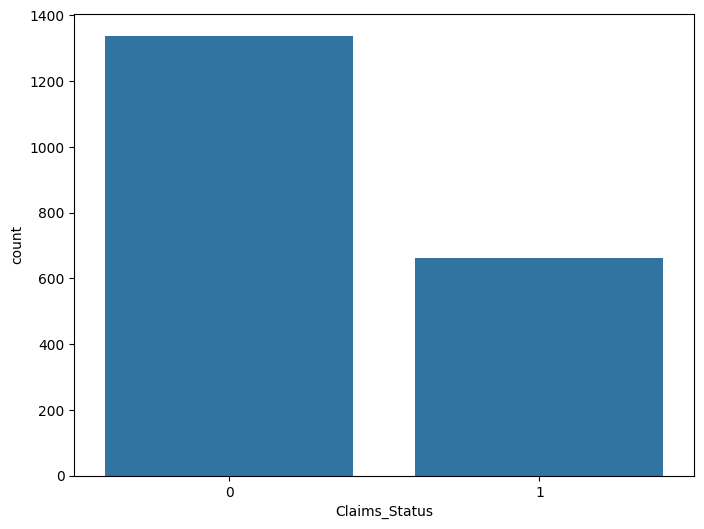

In [12]:
# Creating a count plot to visualize the distribution of claim status
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Claims_Status')

In [13]:
##Grouping by Frequeny of claims against the status to understand the distribution
df.groupby('Claims_Status')['Claims_Frequency'].value_counts()

Claims_Status  Claims_Frequency
0              0                   1338
1              1                    529
               2                    114
               3                     17
               4                      1
               5                      1
Name: count, dtype: int64

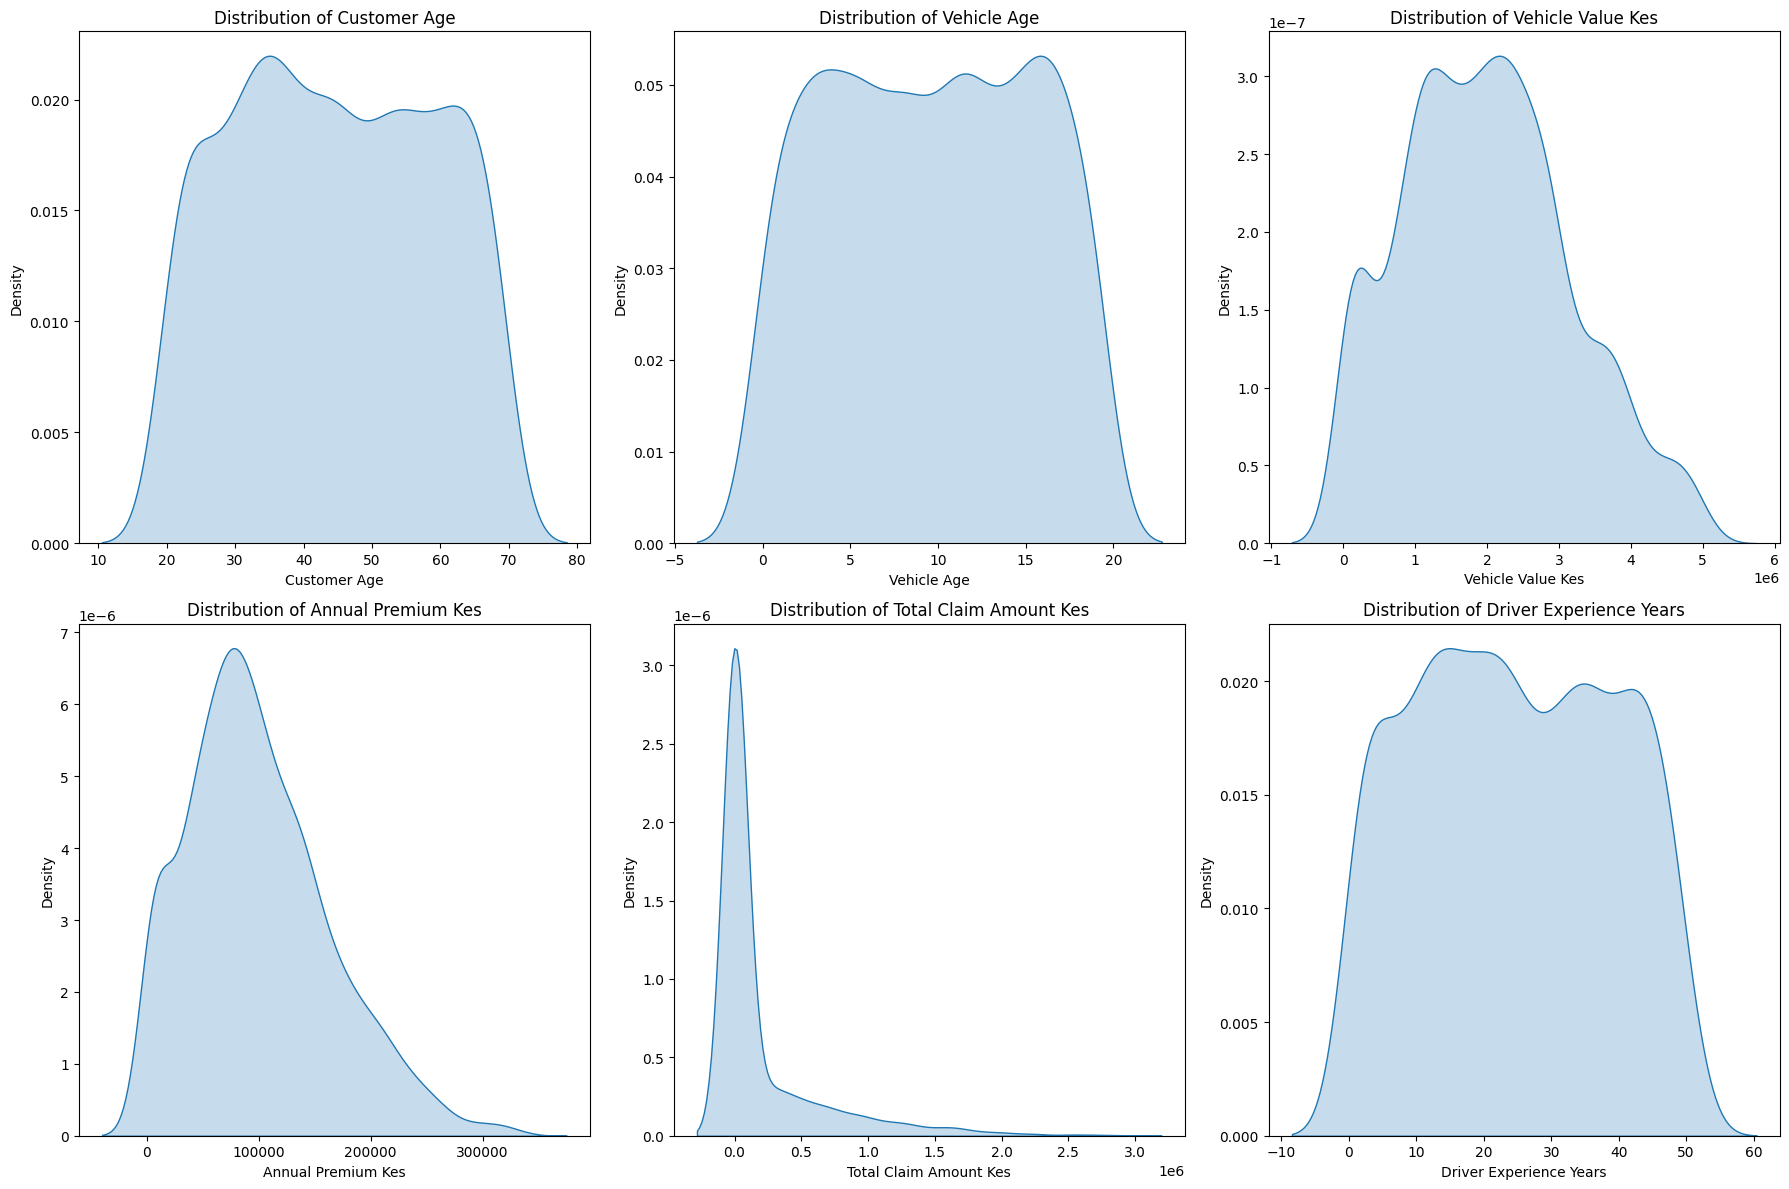

In [14]:
##Defining numerical columns and plotting distributions
numerical = df.select_dtypes(include=['int64']).drop(columns=['Claims_Status', 'Policy_Term_Months', 'Year','Vehicle_Engine_Capacity','Claims_Frequency','No_Claim_Bonus_%','Previous_Claims_Count']).columns

num_cols = len(numerical)
rows = math.ceil(num_cols / 3)

plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical, 1):
  plt.subplot(rows, 3, i)

  sns.kdeplot(df[col], fill=True)

  title = " ".join([x.title() for x in col.split("_")])
  plt.title(f"Distribution of {title}")
  plt.xlabel(title)

plt.tight_layout()
plt.show()

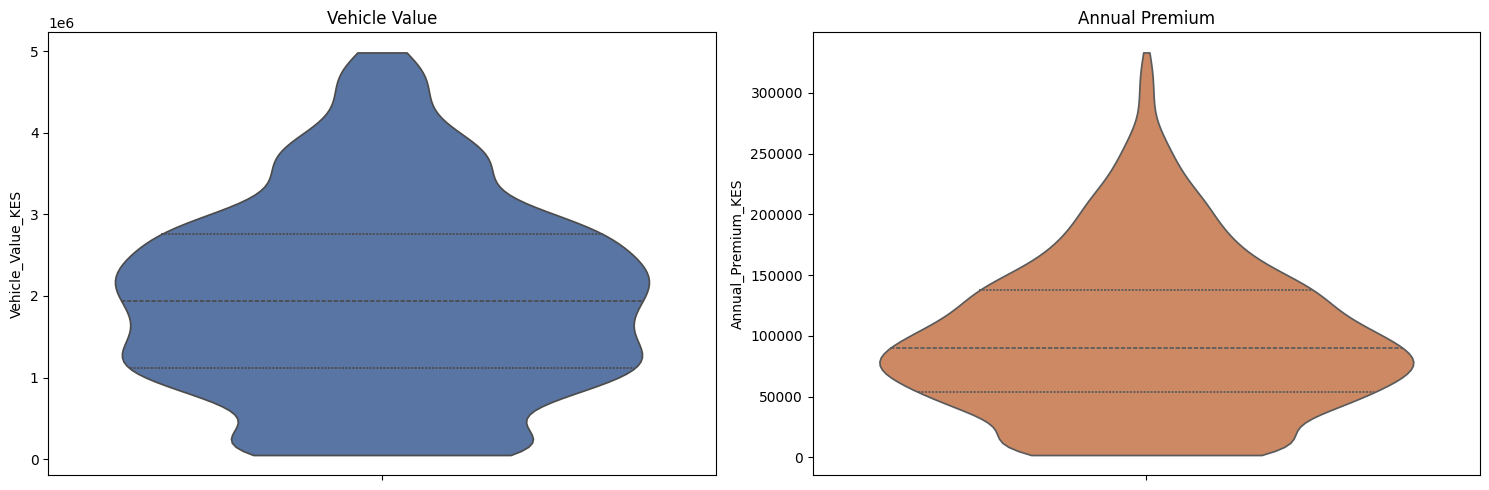

In [15]:
##Plotting Violin Plot for data distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
palette = ["#4C72B0", "#DD8452"]
sns.violinplot(
  y=df['Vehicle_Value_KES'],
  ax=axes[0],
  color=palette[0],
  inner="quartile",
  cut=0
)
axes[0].set_title('Vehicle Value')

sns.violinplot(
  y=df['Annual_Premium_KES'],
  ax=axes[1],
  color=palette[1],
  inner="quartile",
  cut=0
)
axes[1].set_title('Annual Premium')

plt.tight_layout()
plt.show()


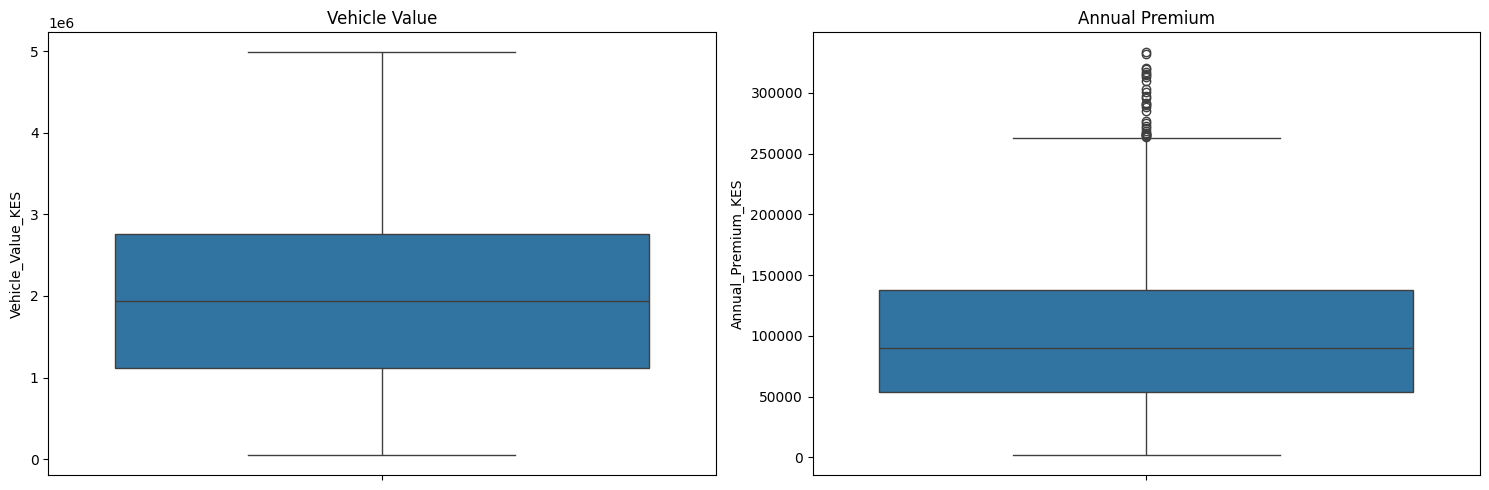

In [16]:
##Plotting a boxplot to check for outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y=df['Vehicle_Value_KES'], ax=axes[0])
axes[0].set_title('Vehicle Value')

sns.boxplot(y=df['Annual_Premium_KES'], ax=axes[1])
axes[1].set_title('Annual Premium')

plt.tight_layout()
plt.show(

)

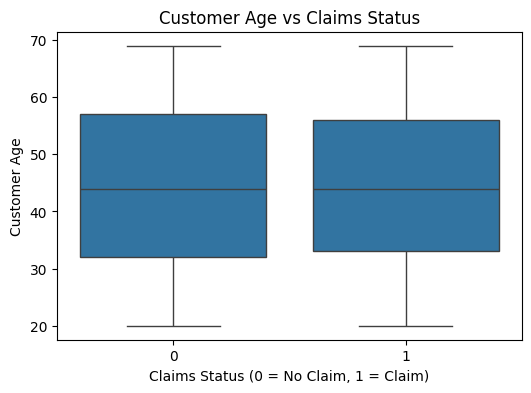

In [17]:
##Univariate analysis of Customer Age and Claim Status
plt.figure(figsize=(6, 4))
sns.boxplot(
  x="Claims_Status",
  y="Customer_Age",
  data=df
)
plt.title("Customer Age vs Claims Status")
plt.xlabel("Claims Status (0 = No Claim, 1 = Claim)")
plt.ylabel("Customer Age")
plt.show()


/tmp/ipython-input-2196309431.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claim_rate_age = df.groupby("Customer_Age_Band")["Claims_Status"].mean()


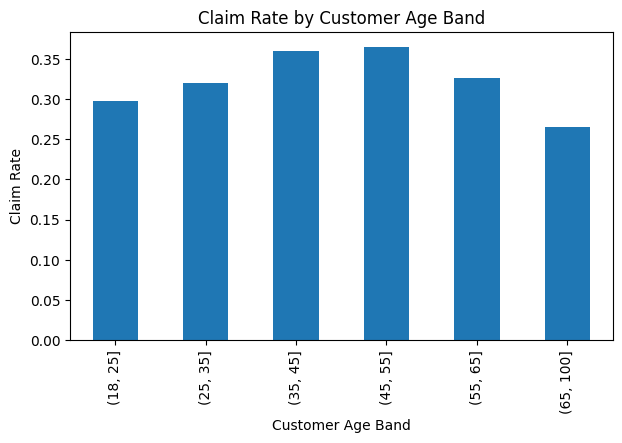

In [18]:
##Defining Age bins and plotting against Claims Rate
df["Customer_Age_Band"] = pd.cut(
  df["Customer_Age"],
  bins=[18, 25, 35, 45, 55, 65, 100]
)

claim_rate_age = df.groupby("Customer_Age_Band")["Claims_Status"].mean()

claim_rate_age.plot(kind="bar", figsize=(7, 4))
plt.title("Claim Rate by Customer Age Band")
plt.ylabel("Claim Rate")
plt.xlabel("Customer Age Band")
plt.show()

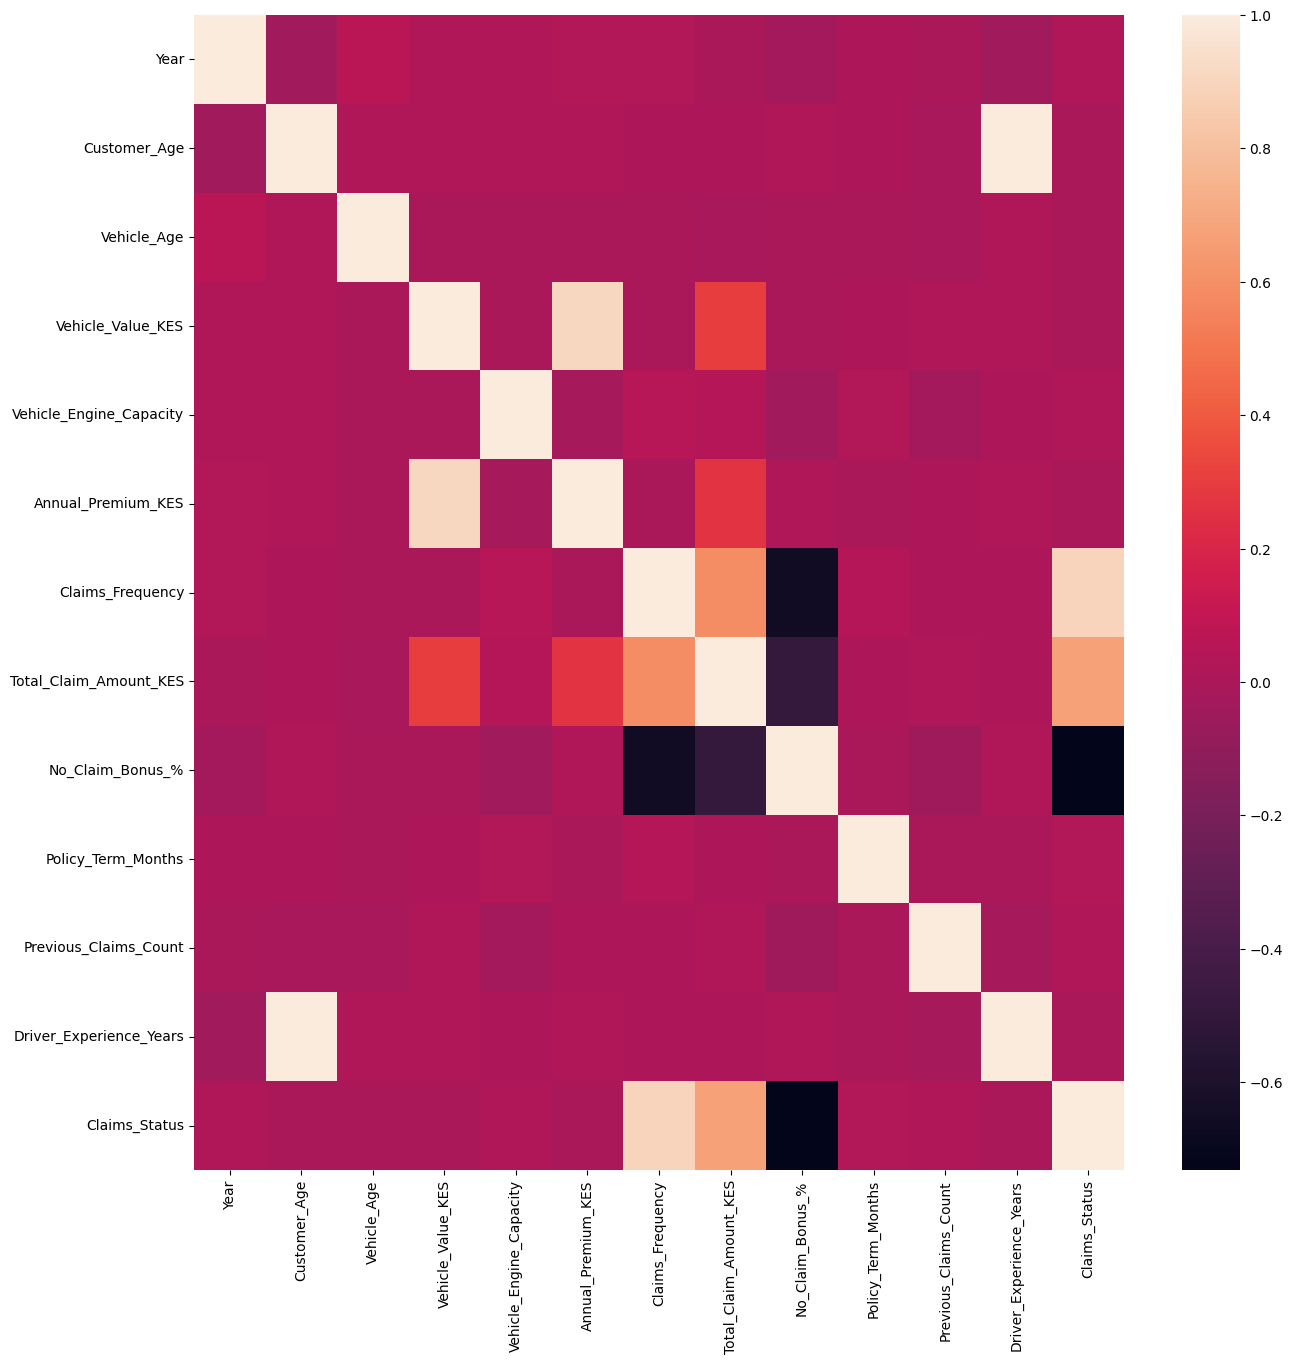

In [19]:
#checking the most correlated variables to Claims status
num_columns = df.select_dtypes(include = ["int64", "float"]).columns
correlation_matrix = df[num_columns].corr()
plt.figure(figsize = (15,15))
sns.heatmap(correlation_matrix)
plt.show()

In [20]:
##List of the top 5 most correlated variables to the claim status
top_corr = correlation_matrix['Claims_Status'].sort_values(ascending = False)
top_corr.head(n=5)

,Claims_Status
Claims_Status,1.000000
Claims_Frequency,0.893330
Total_Claim_Amount_KES,0.670176
Policy_Term_Months,0.029640
Previous_Claims_Count,0.025467


## Data Preprocessing & Feature Engineering

In [21]:
##Dropping the accident cause column
df.drop(['Accident_Cause'], inplace =True)

In [22]:
df.head()

,Year,Policy_ID,Customer_Age,Gender,Region,Vehicle_Type,Vehicle_Age,Vehicle_Value_KES,Vehicle_Engine_Capacity,Use_Purpose,Annual_Premium_KES,Claims_Frequency,Total_Claim_Amount_KES,No_Claim_Bonus_%,Policy_Term_Months,Previous_Claims_Count,Driver_Experience_Years,Third_Party_Only,Claims_Status,Customer_Age_Band
0,2023,P202300001,58,Male,Nakuru,PSV,19,3229084,2000,Business,203851,1,866500,0,6,0,38,Yes,1,"(55, 65]"
1,2023,P202300002,43,Male,Thika,Private,3,1739911,2000,Taxi,64471,0,0,20,6,2,22,No,0,"(35, 45]"
2,2023,P202300003,40,Male,Kakamega,Private,0,2781931,1500,Business,146378,0,0,50,12,0,22,Yes,0,"(35, 45]"
3,2023,P202300004,46,Male,Nakuru,Private,9,1154811,2500,Personal,59810,0,0,30,12,0,26,No,0,"(45, 55]"
4,2023,P202300005,63,Female,Nakuru,Commercial,19,3452991,1000,Business,143266,0,0,30,6,0,41,No,0,"(55, 65]"


In [23]:
##drop policy_id, unique identifier of a policy to reduce bias of individual claim characteristics on model
df.drop(columns=['Policy_ID'], inplace =True)

In [24]:
##Create a copy of the initial data
df_copy = df.copy()

In [25]:
##Identifying columns for encoding
categorical_cols = df_copy.select_dtypes(include='object').columns
numerical_cols = df_copy.select_dtypes(exclude='object').columns
One_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = One_hot.fit_transform(df_copy[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=One_hot.get_feature_names_out(categorical_cols), index=df_copy.index)
df_encoded = pd.concat([df_copy[numerical_cols], encoded_df], axis=1)

In [26]:
df_encoded.head()

,Year,Customer_Age,Vehicle_Age,Vehicle_Value_KES,Vehicle_Engine_Capacity,Annual_Premium_KES,Claims_Frequency,Total_Claim_Amount_KES,No_Claim_Bonus_%,Policy_Term_Months,...,Region_Thika,Vehicle_Type_Commercial,Vehicle_Type_Motorcycle,Vehicle_Type_PSV,Vehicle_Type_Private,Use_Purpose_Business,Use_Purpose_Personal,Use_Purpose_Taxi,Third_Party_Only_No,Third_Party_Only_Yes
0,2023,58,19,3229084,2000,203851,1,866500,0,6,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2023,43,3,1739911,2000,64471,0,0,20,6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2023,40,0,2781931,1500,146378,0,0,50,12,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,2023,46,9,1154811,2500,59810,0,0,30,12,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,2023,63,19,3452991,1000,143266,0,0,30,6,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [27]:
df_encoded.groupby('Claims_Status')['No_Claim_Bonus_%'].describe()


,count,mean,std,min,25%,50%,75%,max
Claims_Status,,,,,,,,
0,1338.0,27.660688,14.838395,10.0,12.5,30.0,50.0,50.0
1,662.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [28]:
#Separating X and Y target features and dropping columns likely to result in data leakage
X = df_encoded.drop(columns = ['Claims_Status','Claims_Frequency', 'Previous_Claims_Count','Total_Claim_Amount_KES','No_Claim_Bonus_%', 'Customer_Age_Band'])
y = df_encoded['Claims_Status']

In [29]:
#Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Train_size:', X_train.shape, y_train.shape)
print('Test_size:', X_test.shape, y_test.shape)

Train_size: (1600, 27) (1600,)
Test_size: (400, 27) (400,)


## Training Baseline Models

In [30]:
##Logistic Regression
lr_model = LogisticRegression(random_state = 42)

#Scaling Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled =  scaler.transform(X_test)


lr_model.fit(x_train_scaled, y_train)
y_pred_lr = lr_model.predict(x_test_scaled)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       256
           1       0.00      0.00      0.00       144

    accuracy                           0.64       400
   macro avg       0.32      0.50      0.39       400
weighted avg       0.41      0.64      0.50       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
def plot_auc_and_confusion_matrix(y_true_train, y_pred_proba_train, y_pred_train, y_true_test, y_pred_proba_test, y_pred_test):
  auc_train = roc_auc_score(y_true_train, y_pred_proba_train)
  auc_test = roc_auc_score(y_true_test, y_pred_proba_test)

  print(f"Training AUC: {auc_train:.2f}")
  print(f"Test AUC: {auc_test:.2f}")

  plt.figure(figsize=(15, 5))

  # Confusion Matrix for Training
  plt.subplot(1, 2, 1)
  cm_train = confusion_matrix(y_true_train, y_pred_train)
  disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
  disp_train.plot(ax=plt.gca(), cmap='Blues')
  plt.title('Training Confusion Matrix')

  # Confusion Matrix for Test
  plt.subplot(1, 2, 2)
  cm_test = confusion_matrix(y_true_test, y_pred_test)
  disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
  disp_test.plot(ax=plt.gca(), cmap='Blues')
  plt.title('Test Confusion Matrix')

  plt.tight_layout()
  plt.show()

Training AUC: 1.00
Test AUC: 0.47


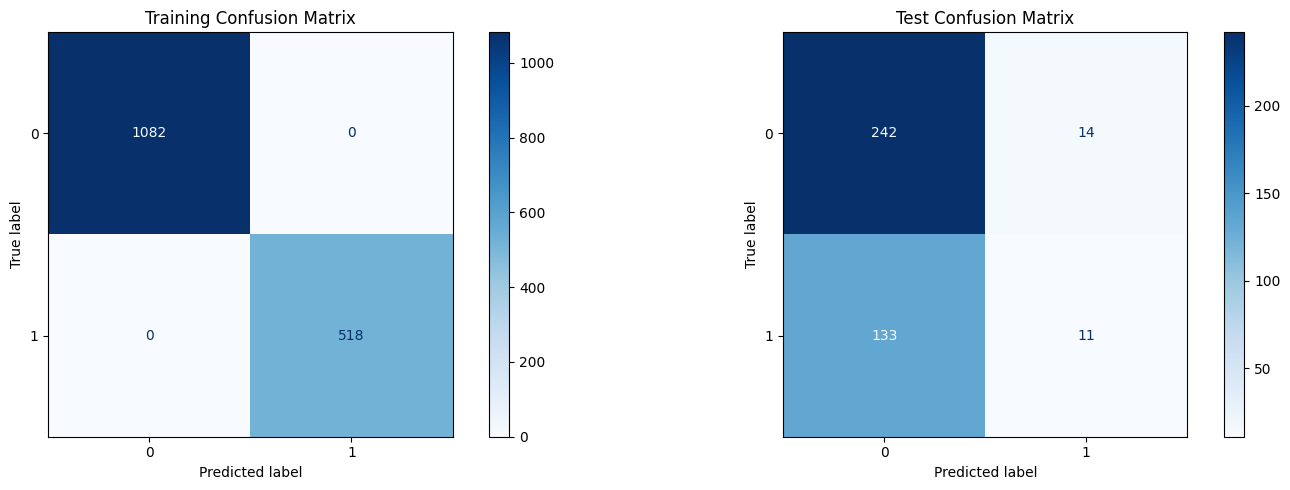

In [34]:
#Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)
y_pred_rf  = rf_clf.predict(X_train)
y_proba_rf = rf_clf.predict_proba(X_train)[:, 1]


y_pred_randomf_train    = rf_clf.predict(X_train)
y_proba_randomf_train   = rf_clf.predict_proba(X_train)[:, 1]

y_pred_randomf_test   = rf_clf.predict(X_test)
y_proba_randomf_test  = rf_clf.predict_proba(X_test)[:, 1]


plot_auc_and_confusion_matrix(y_train, y_proba_randomf_train, y_pred_randomf_train, y_test, y_proba_randomf_test, y_pred_randomf_test)

In [35]:
#Evaluating the model
print(classification_report(y_test, y_pred_randomf_test))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77       256
           1       0.44      0.08      0.13       144

    accuracy                           0.63       400
   macro avg       0.54      0.51      0.45       400
weighted avg       0.57      0.63      0.54       400

